In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn import mixture

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [55]:
%R require(ggplot2)

array([1], dtype=int32)

In [56]:
def calc_mode(data, eval_N = 10000):
    eval_sizes = np.linspace(np.min(data), np.max(data), eval_N)
    return eval_sizes[np.argmax(sp.stats.gaussian_kde(data)(eval_sizes))]

In [57]:
nuclei = pd.read_excel('../../../data/Nuclei_diameters+calculated_volumes.xlsx', usecols=np.arange(7))
nuclei = pd.melt(nuclei, var_name='sample', value_name='diameter').dropna()

nuclei['volume'] = 4/3*np.pi*(nuclei['diameter']/2)

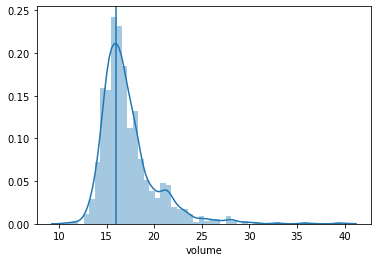

In [59]:
sns.distplot(nuclei['volume'])
plt.axvline(mode(nuclei['volume']))
plt.show()

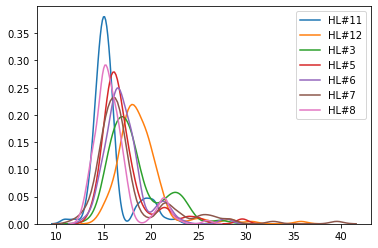

In [58]:
for name, data in nuclei.groupby('sample'):
    sns.kdeplot(data['volume'], label=name)
plt.show()

In [219]:
modes = nuclei.groupby('sample').apply(lambda data: calc_mode(data['volume']))
modes.name = 'mode'
modes

sample
HL#11    15.045545
HL#12    18.250855
HL#3     16.969229
HL#5     16.147348
HL#6     16.604768
HL#7     16.010424
HL#8     15.356593
Name: mode, dtype: float64

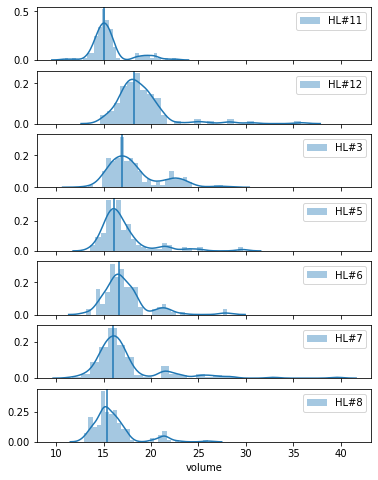

In [227]:
groupby = nuclei.groupby('sample')
fig, axs = plt.subplots(len(groupby), sharex=True, figsize=(6,8))
for (name, data), ax in zip(nuclei.groupby('sample'), axs):
    sns.distplot(data['volume'], label=name, bins=30, ax=ax, axlabel='')
    ax.axvline(mode(data['volume']))
    ax.legend()

ax.set_xlabel('volume')
plt.show()

In [73]:
nuclei = nuclei.join(modes, on='sample')

In [192]:
nuclei['normalised_volume'] = nuclei['volume'] / nuclei['mode']

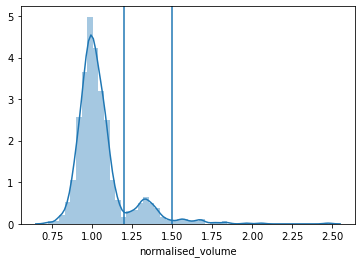

In [315]:
sns.distplot(nuclei['normalised_volume'])
threshold_2n = 1.2
threshold_4n = 1.5
plt.axvline(threshold_2n)
plt.axvline(threshold_4n)

In [318]:
nuclei['ploidy_threshold'] = [2 if nv < threshold_2n else (4 if nv < threshold_4n else 6) for nv in nuclei['normalised_volume']]

In [319]:
nuclei.groupby(['sample', 'ploidy_threshold']).size() / nuclei.groupby(['sample']).size()

sample  ploidy_threshold
HL#11   2                   0.858407
        4                   0.132743
        6                   0.008850
HL#12   2                   0.941176
        4                   0.029412
        6                   0.029412
HL#3    2                   0.793651
        4                   0.190476
        6                   0.015873
HL#5    2                   0.875862
        4                   0.089655
        6                   0.034483
HL#6    2                   0.883721
        4                   0.100775
        6                   0.015504
HL#7    2                   0.818182
        4                   0.106061
        6                   0.075758
HL#8    2                   0.901515
        4                   0.090909
        6                   0.007576
dtype: float64

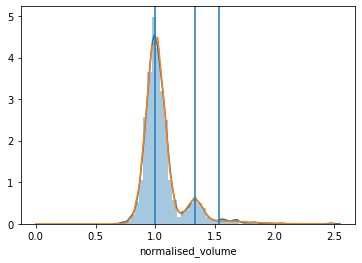

In [347]:
n_components = 3
means_init= np.linspace(1, 1.7, n_components).reshape(-1, 1)
weights_init=[0.8] + (n_components - 1) * [0.2/(n_components - 1)]

clf = mixture.GaussianMixture(n_components=n_components, max_iter=10000, 
                              weights_init=weights_init,
                              means_init=means_init, random_state=0)

clf.fit(nuclei['normalised_volume'].values.reshape(-1, 1))

sns.distplot(nuclei['normalised_volume'])
x = np.linspace(0, 2.5)
plt.plot(x, np.exp(clf.score_samples(x.reshape(-1, 1))))

for pos in clf.means_:
    plt.axvline(pos)

In [348]:
clf.weights_

array([0.86534471, 0.08894465, 0.04571065])

In [349]:
clf.means_

array([[1.00111698],
       [1.33005823],
       [1.53149236]])

In [350]:
np.sqrt(clf.covariances_)

array([[[0.07460959]],

       [[0.06193005]],

       [[0.28164425]]])

In [351]:
clf.predict_proba(nuclei['normalised_volume'].values.reshape(-1, 1))

array([[9.97905790e-01, 1.07085616e-09, 2.09420895e-03],
       [9.76541475e-01, 2.01277748e-16, 2.34585250e-02],
       [8.88868987e-05, 9.06410693e-01, 9.35004203e-02],
       ...,
       [9.97924372e-01, 3.60637212e-09, 2.07562454e-03],
       [9.97854839e-01, 4.60091301e-10, 2.14516050e-03],
       [9.94680006e-01, 2.23857694e-05, 5.29760858e-03]])

In [353]:
nuclei['ploidy'] = 2*(clf.predict(nuclei['normalised_volume'].values.reshape(-1, 1))+1)

nuclei.groupby(['sample', 'ploidy']).size() / nuclei.groupby(['sample']).size()

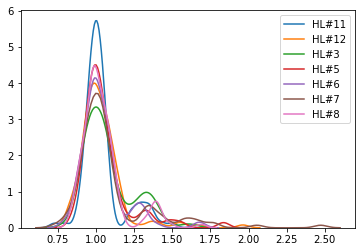

In [354]:
for name, data in nuclei.groupby('sample'):
    sns.kdeplot(data['normalised_volume'], label=name)
plt.show()

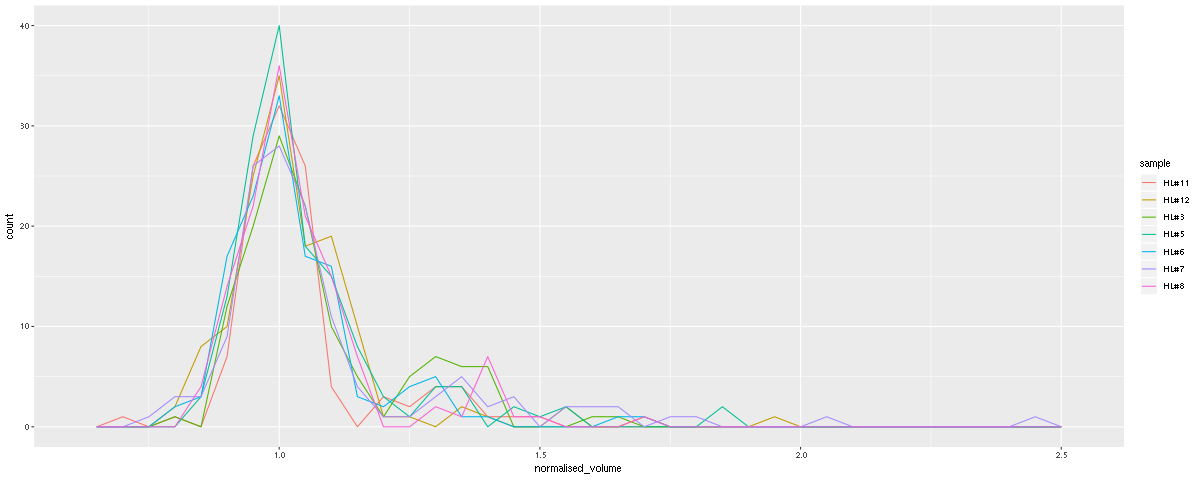

In [355]:
%%R -i nuclei -w 1200
ggplot(nuclei, aes(x=normalised_volume, color=sample)) + geom_freqpoly(binwidth=0.05)

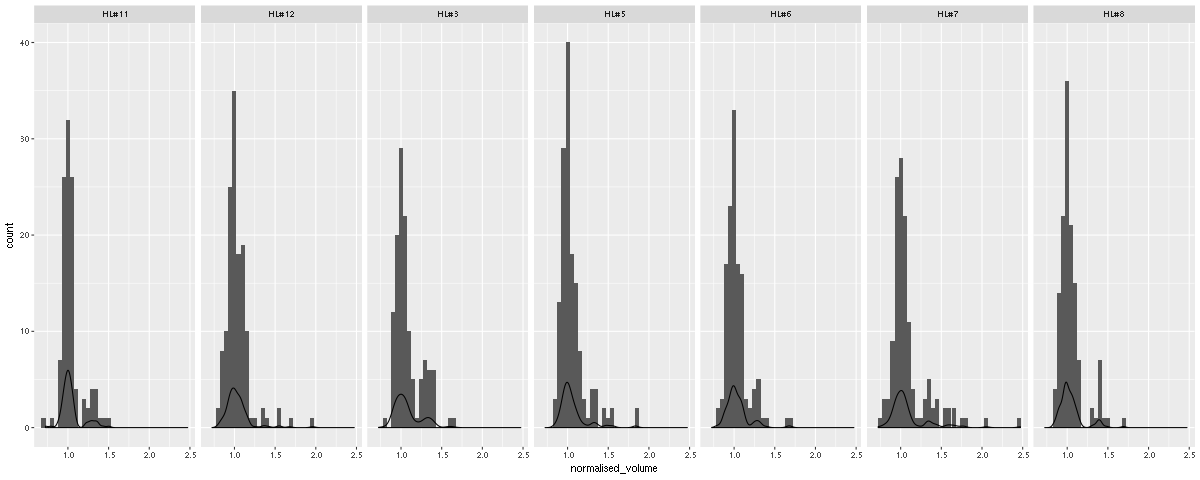

In [356]:
%%R -i nuclei -w 1200
ggplot(nuclei, aes(x=normalised_volume)) + geom_histogram(binwidth=0.05) + geom_density() + facet_wrap( ~ sample, ncol=7)

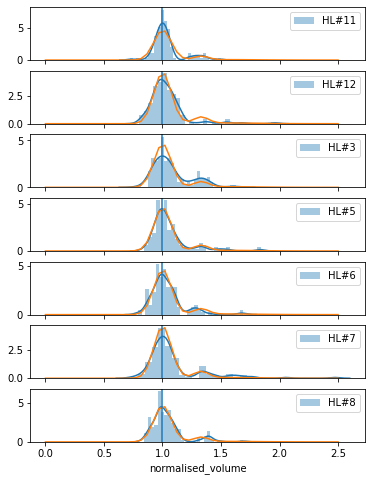

In [357]:
groupby = nuclei.groupby('sample')
fig, axs = plt.subplots(len(groupby), sharex=True, figsize=(6,8))
for (name, data), ax in zip(nuclei.groupby('sample'), axs):
    sns.distplot(data['normalised_volume'], label=name, bins=30, ax=ax, axlabel='')
    ax.plot(x, np.exp(clf.score_samples(x.reshape(-1, 1))))
    ax.axvline(1)
    ax.legend()

ax.set_xlabel('normalised_volume')
plt.show()

## Uncertainties

In [358]:
nuclei.head()

,sample,diameter,volume,mode,normalised volume,normalised_volume,ploidy,ploidy_threshold
0,HL#3,7.7,16.126842,16.969229,0.950358,0.950358,2,2
1,HL#3,6.4,13.404129,16.969229,0.789908,0.789908,2,2
2,HL#3,11.0,23.038346,16.969229,1.357654,1.357654,4,4
3,HL#3,7.6,15.917403,16.969229,0.938016,0.938016,2,2
4,HL#3,8.1,16.964600,16.969229,0.999727,0.999727,2,2


In [468]:
def sample_nuclei(nuclei, random_state=None):
    return nuclei.groupby('sample', group_keys=False).apply(lambda x: x.sample(frac=1, replace=True, random_state=random_state))

In [469]:
def ploidy_levels(nuclei):
    n_components = 3
    means_init= np.linspace(1, 1.7, n_components).reshape(-1, 1)
    weights_init=[0.8] + (n_components - 1) * [0.2/(n_components - 1)]

    clf = mixture.GaussianMixture(n_components=n_components, max_iter=10000, 
                                  weights_init=weights_init,
                                  means_init=means_init, random_state=0)

    labels = clf.fit_predict(nuclei['normalised_volume'].values.reshape(-1, 1))
    ploidy = 2*(labels+1)

    return ploidy

In [476]:
def sample_ploidy_fractions(nuclei, random_state=None):
    if random_state is None:
        random_state = None
    nuclei = sample(nuclei, random_state=random_state)
    ploidy = ploidy_levels(nuclei)
    nuclei['ploidy'] = ploidy
    
    ploidy_fractions = pd.DataFrame(nuclei.groupby(['sample', 'ploidy']).size() / nuclei.groupby(['sample']).size(), columns=['fraction'])
#     if random_state is None:
#         ploidy_fractions['random_state'] = np.nan
#     else:
    ploidy_fractions['random_state'] = random_state
    return ploidy_fractions.reset_index()

In [484]:
N_bootstrap = 1000
bootstrap_result = pd.concat([sample_ploidy_fractions(nuclei, random_state) for random_state in np.arange(100)])

In [491]:
ploidy = bootstrap_result.groupby(['sample', 'ploidy'])['fraction'].agg(['mean', 'std']).reset_index()
ploidy['ploidy'] = pd.Categorical(ploidy['ploidy'])
ploidy

,sample,ploidy,mean,std
0,HL#11,2,0.853894,0.034801
1,HL#11,4,0.141239,0.037628
2,HL#11,6,0.018027,0.012631
3,HL#12,2,0.928309,0.029622
4,HL#12,4,0.056075,0.030904
5,HL#12,6,0.023109,0.014880
6,HL#3,2,0.778016,0.041973
7,HL#3,4,0.212937,0.046716
8,HL#3,6,0.023810,0.020464
9,HL#5,2,0.872276,0.029136
